In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [4]:
day=pd.read_csv('day.csv')

In [5]:
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1/1/2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2/1/2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,3/1/2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,4/1/2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,5/1/2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [6]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [7]:
day.isnull().mean()

instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

In [8]:
day.shape

(730, 16)

In [9]:
day.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

### There are 730 rows and 16 columns. Also, we see that there are no missing values in the dataset

## On analysing we find that the following columns can be removed 
#### instant - This is just some index number associated with each column so can be ignored
#### dteday - This is a column which contains date which looks to be a duplicate of month and year columns and can be removed
#### Casual and Registered can also be removed as these can be all together indicated by cnt column and the goal is to determine number users and not the category

In [10]:
day.drop(['instant','dteday','casual','registered'],axis=1,inplace=True)

In [11]:
day.shape

(730, 12)

In [12]:
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


## Analysing the predictor numerial variables wrt to target variable
#### Lets plot a scatter plot to understand how better are these predictor variables contribute to the targetted variable

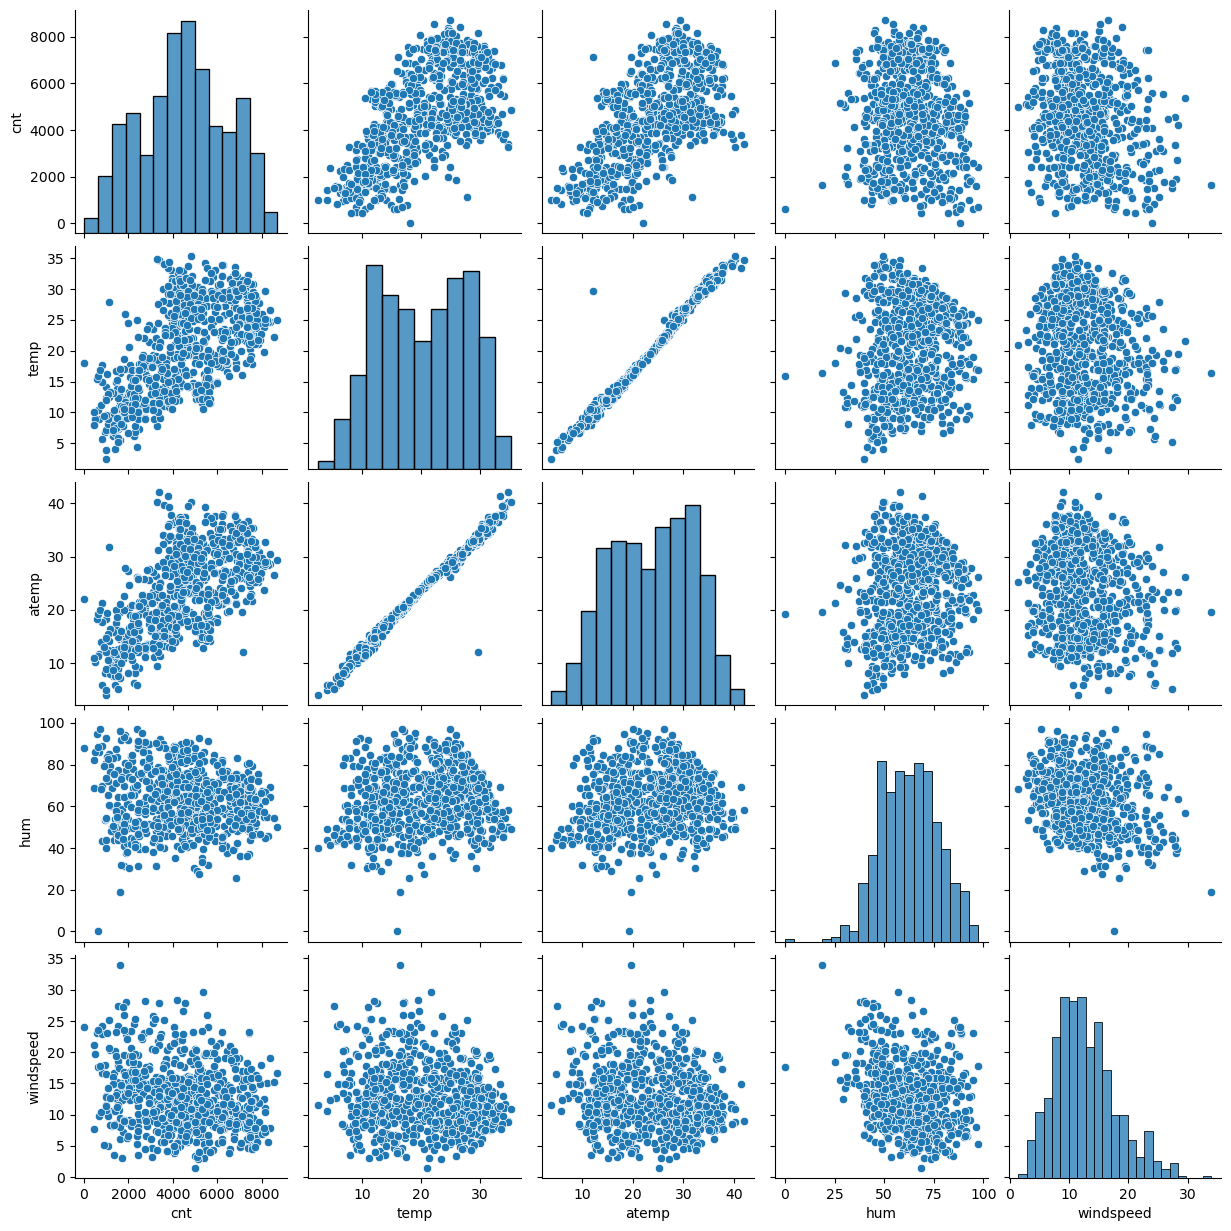

In [13]:
sns.pairplot(data=day, vars=['cnt', 'temp', 'atemp', 'hum','windspeed'])
plt.show()

#### Analysing the plots we see that there are variables which are linearly related to cnt. Therefore we can consider using Linear Regression

## Analysing the Categorical Variables
### Lets first map the variables to the values as per data dictionary for better usability

In [14]:
day.season = day.season.map({1:'spring',2:'summer',3:'fall',4:'winter'})

In [15]:
day.weathersit  = day.weathersit .map({1:'clr/cloudy',2:'Mist',3:'Rain',4:'Snow/Ice'})

In [16]:
day.weekday  = day.weekday.map({0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'})

In [17]:
import calendar
day['mnth'] = day['mnth'].apply(lambda x: calendar.month_abbr[x])

In [18]:
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Monday,1,clr/cloudy,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Tuesday,1,clr/cloudy,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Wednesday,1,clr/cloudy,9.305237,11.46350,43.6957,12.522300,1600


In [19]:
day.holiday.nunique

<bound method IndexOpsMixin.nunique of 0      0
1      0
2      0
3      0
4      0
      ..
725    0
726    0
727    0
728    0
729    0
Name: holiday, Length: 730, dtype: int64>

In [20]:
day.workingday.nunique

<bound method IndexOpsMixin.nunique of 0      0
1      0
2      1
3      1
4      1
      ..
725    1
726    1
727    0
728    0
729    1
Name: workingday, Length: 730, dtype: int64>

### Now lets visualise the categorical variables with respect to target variable "cnt"

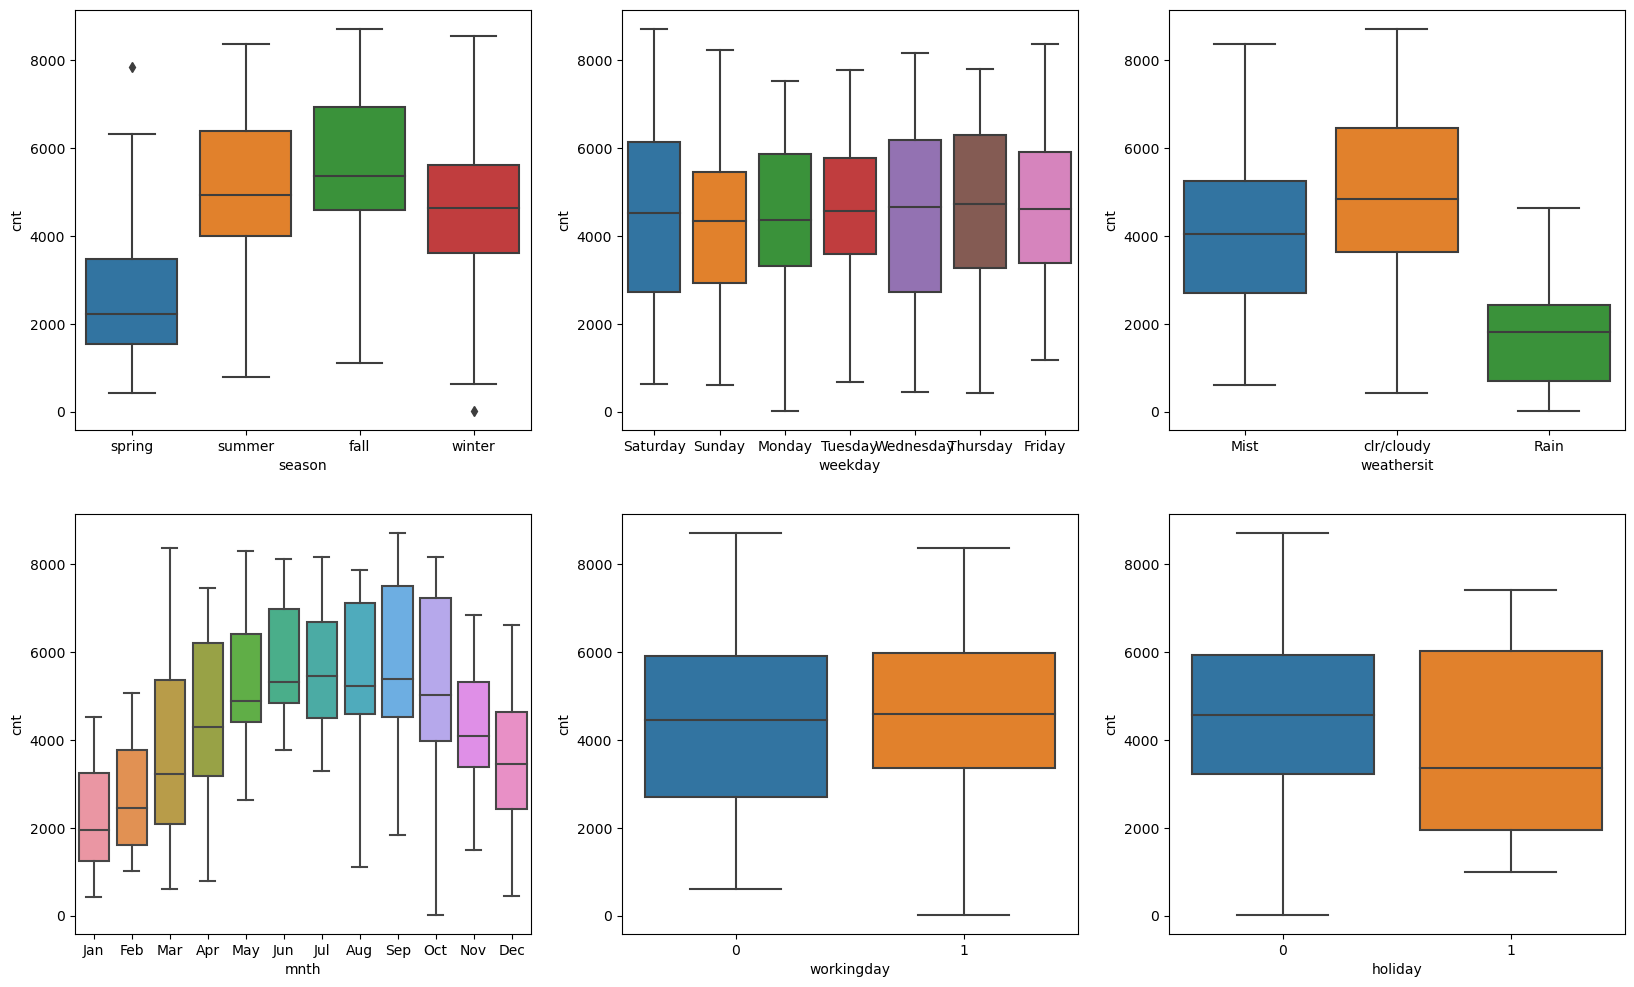

In [21]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = day)
plt.subplot(2,3,2)
sns.boxplot(x = 'weekday', y = 'cnt', data = day)
plt.subplot(2,3,3)
sns.boxplot(x = 'weathersit', y = 'cnt', data = day)
plt.subplot(2,3,4)
sns.boxplot(x = 'mnth', y = 'cnt', data = day)
plt.subplot(2,3,5)
sns.boxplot(x = 'workingday', y = 'cnt', data = day)
plt.subplot(2,3,6)
sns.boxplot(x = 'holiday', y = 'cnt', data = day)
plt.show()

## Conclusions based on Boxplot
### - The Bike Sharing seem to be high in Summer and Fall seasons i.e around 5000 to 6000
### - There is no much difference in Bike Sharing particularly to any day in a week and seems to be almost equal as per mean calculated in Boxplot.
### - During Clear or cloudy weather conditions, people tend to use Bike Sharing more
### - Also, we see that in the months of May to September , this service is most used.
### - There is no much noticeable change in Bike Sharing between holiday and working days

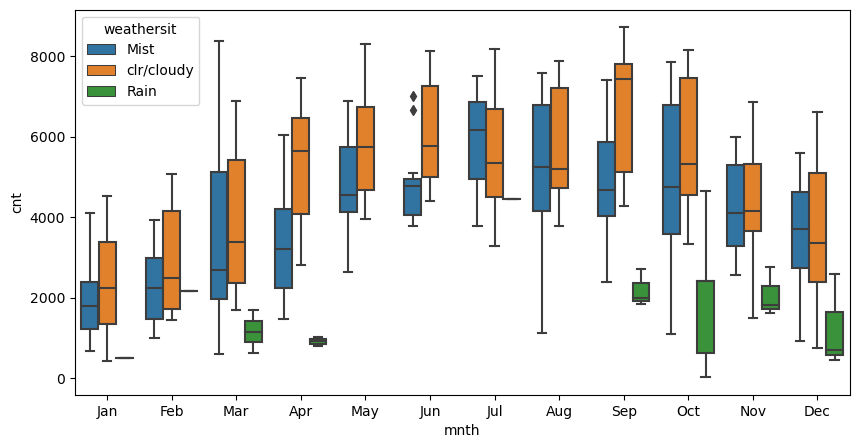

In [22]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'mnth', y = 'cnt', data = day, hue = 'weathersit')
plt.show()

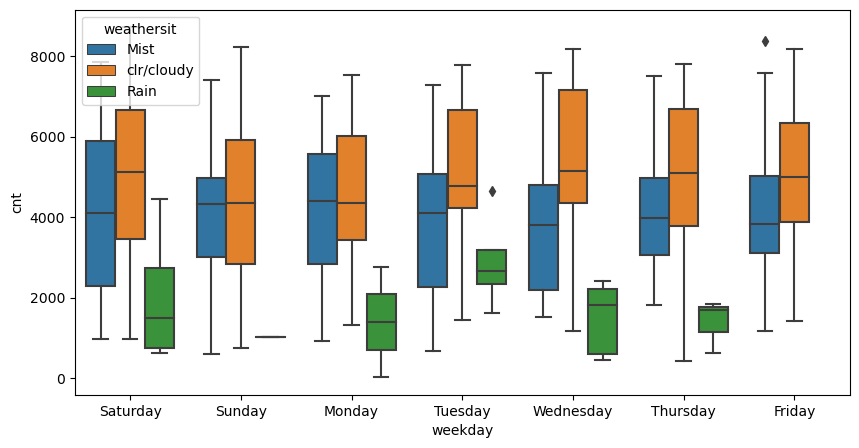

In [23]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'weekday', y = 'cnt', data = day, hue = 'weathersit')
plt.show()

### From the above graphs we see that people tend to use the service more if the weather is Misty or Cloudy and less if it is rainy. This is the same when analysed based on months and weekdays

### Dummy Variables
#### Since the categorical variables have different levels its necessary to create dummy variables

In [24]:
day.shape

(730, 12)

In [25]:
day_season = pd.get_dummies(day.season, drop_first='True')
day_mnth = pd.get_dummies(day.mnth, drop_first='True')
day_weekday = pd.get_dummies(day.weekday, drop_first='True')
day_weathersit = pd.get_dummies(day.weathersit, drop_first='True')

In [26]:
day_con = pd.concat([day,day_season,day_mnth,day_weekday,day_weathersit], axis = 1)

In [27]:
day_con.shape

(730, 34)

In [28]:
day_con.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Rain,clr/cloudy
0,spring,0,Jan,0,Saturday,0,Mist,14.110847,18.18125,80.5833,...,0,0,0,1,0,0,0,0,0,0
1,spring,0,Jan,0,Sunday,0,Mist,14.902598,17.68695,69.6087,...,0,0,0,0,1,0,0,0,0,0
2,spring,0,Jan,0,Monday,1,clr/cloudy,8.050924,9.47025,43.7273,...,0,0,1,0,0,0,0,0,0,1
3,spring,0,Jan,0,Tuesday,1,clr/cloudy,8.200000,10.60610,59.0435,...,0,0,0,0,0,0,1,0,0,1
4,spring,0,Jan,0,Wednesday,1,clr/cloudy,9.305237,11.46350,43.6957,...,0,0,0,0,0,0,0,1,0,1


In [29]:
day_con.drop(["season","mnth","weekday","weathersit"],axis=1,inplace=True)

In [30]:
day_con.shape

(730, 30)

In [31]:
day_con.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'spring', 'summer', 'winter', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul',
       'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Rain', 'clr/cloudy'],
      dtype='object')

In [32]:
day_con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   workingday  730 non-null    int64  
 3   temp        730 non-null    float64
 4   atemp       730 non-null    float64
 5   hum         730 non-null    float64
 6   windspeed   730 non-null    float64
 7   cnt         730 non-null    int64  
 8   spring      730 non-null    uint8  
 9   summer      730 non-null    uint8  
 10  winter      730 non-null    uint8  
 11  Aug         730 non-null    uint8  
 12  Dec         730 non-null    uint8  
 13  Feb         730 non-null    uint8  
 14  Jan         730 non-null    uint8  
 15  Jul         730 non-null    uint8  
 16  Jun         730 non-null    uint8  
 17  Mar         730 non-null    uint8  
 18  May         730 non-null    uint8  
 19  Nov         730 non-null    u

## Train Test Split

In [33]:
np.random.seed(0)
day_train, day_test = train_test_split(day_con, train_size = 0.7, random_state = 100)

In [34]:
day_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Rain,clr/cloudy
576,1,0,1,29.246653,33.1448,70.4167,11.083475,7216,0,0,...,0,0,0,0,0,0,1,0,0,1
426,1,0,0,16.980847,20.6746,62.1250,10.792293,4066,1,0,...,0,0,0,1,0,0,0,0,0,0
728,1,0,0,10.489153,11.5850,48.3333,23.500518,1796,1,0,...,0,0,0,0,1,0,0,0,0,1
482,1,0,0,15.443347,18.8752,48.9583,8.708325,4220,0,1,...,0,0,0,1,0,0,0,0,0,0
111,0,0,1,13.803347,16.0977,72.9583,14.707907,1683,0,1,...,0,0,0,0,0,0,0,0,0,0


## Rescaling the Features
### The predictors which are numerical in nature are resclaed in order to bring all of them to a same scale for further analysis.

In [35]:
scaler = MinMaxScaler()

In [36]:
# Apply scaler() to all the columns except the 'dummy' variables
num_vars = ['temp','atemp','hum','windspeed','cnt']

day_train[num_vars] = scaler.fit_transform(day_train[num_vars])

In [37]:
day_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Rain,clr/cloudy
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,0,0,0,1,0,0,1
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,...,0,0,0,1,0,0,0,0,0,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,...,0,0,0,0,1,0,0,0,0,1
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,1,0,0,0,0,0,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,...,0,0,0,0,0,0,0,0,0,0


In [38]:
day_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Rain,clr/cloudy
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.243137,0.247059,...,0.084314,0.080392,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.029412,0.625490
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.429398,0.431725,...,0.278131,0.272166,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.169124,0.484471
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


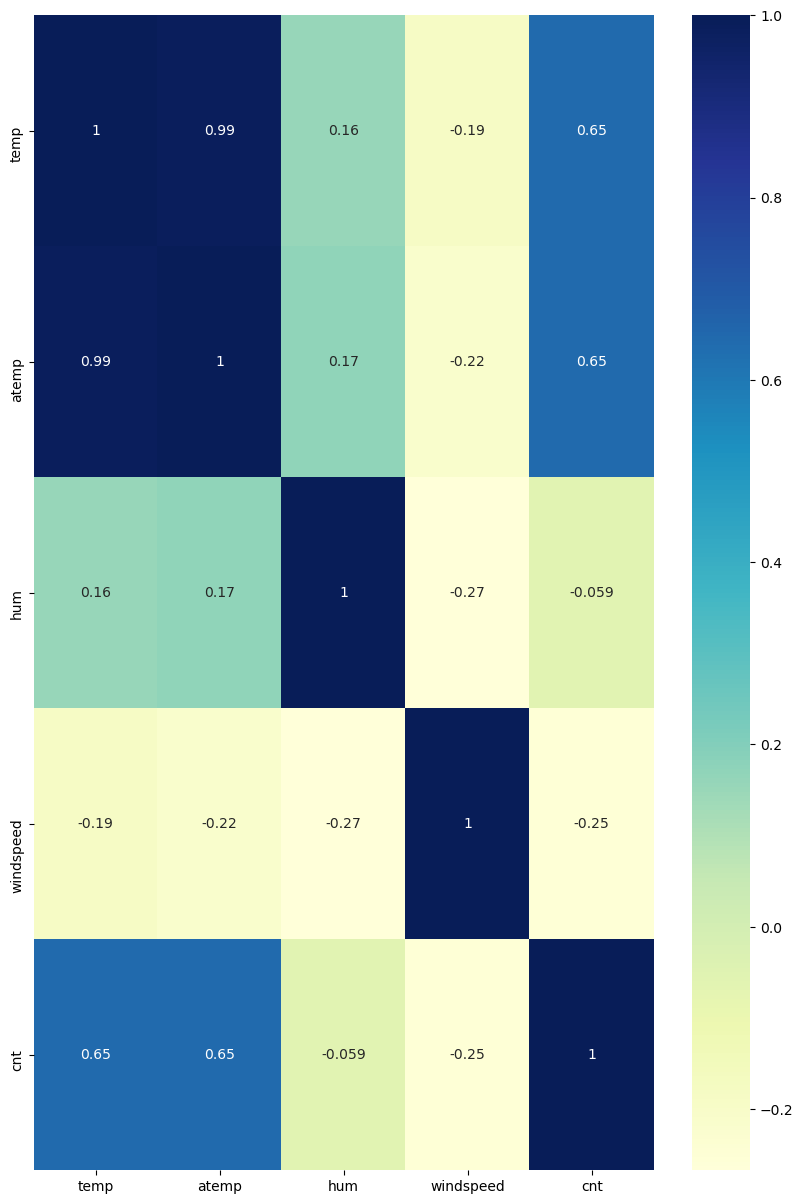

In [39]:
plt.figure(figsize = (10, 15))
sns.heatmap(day_train[num_vars].corr(), annot = True, cmap="YlGnBu")
plt.show()

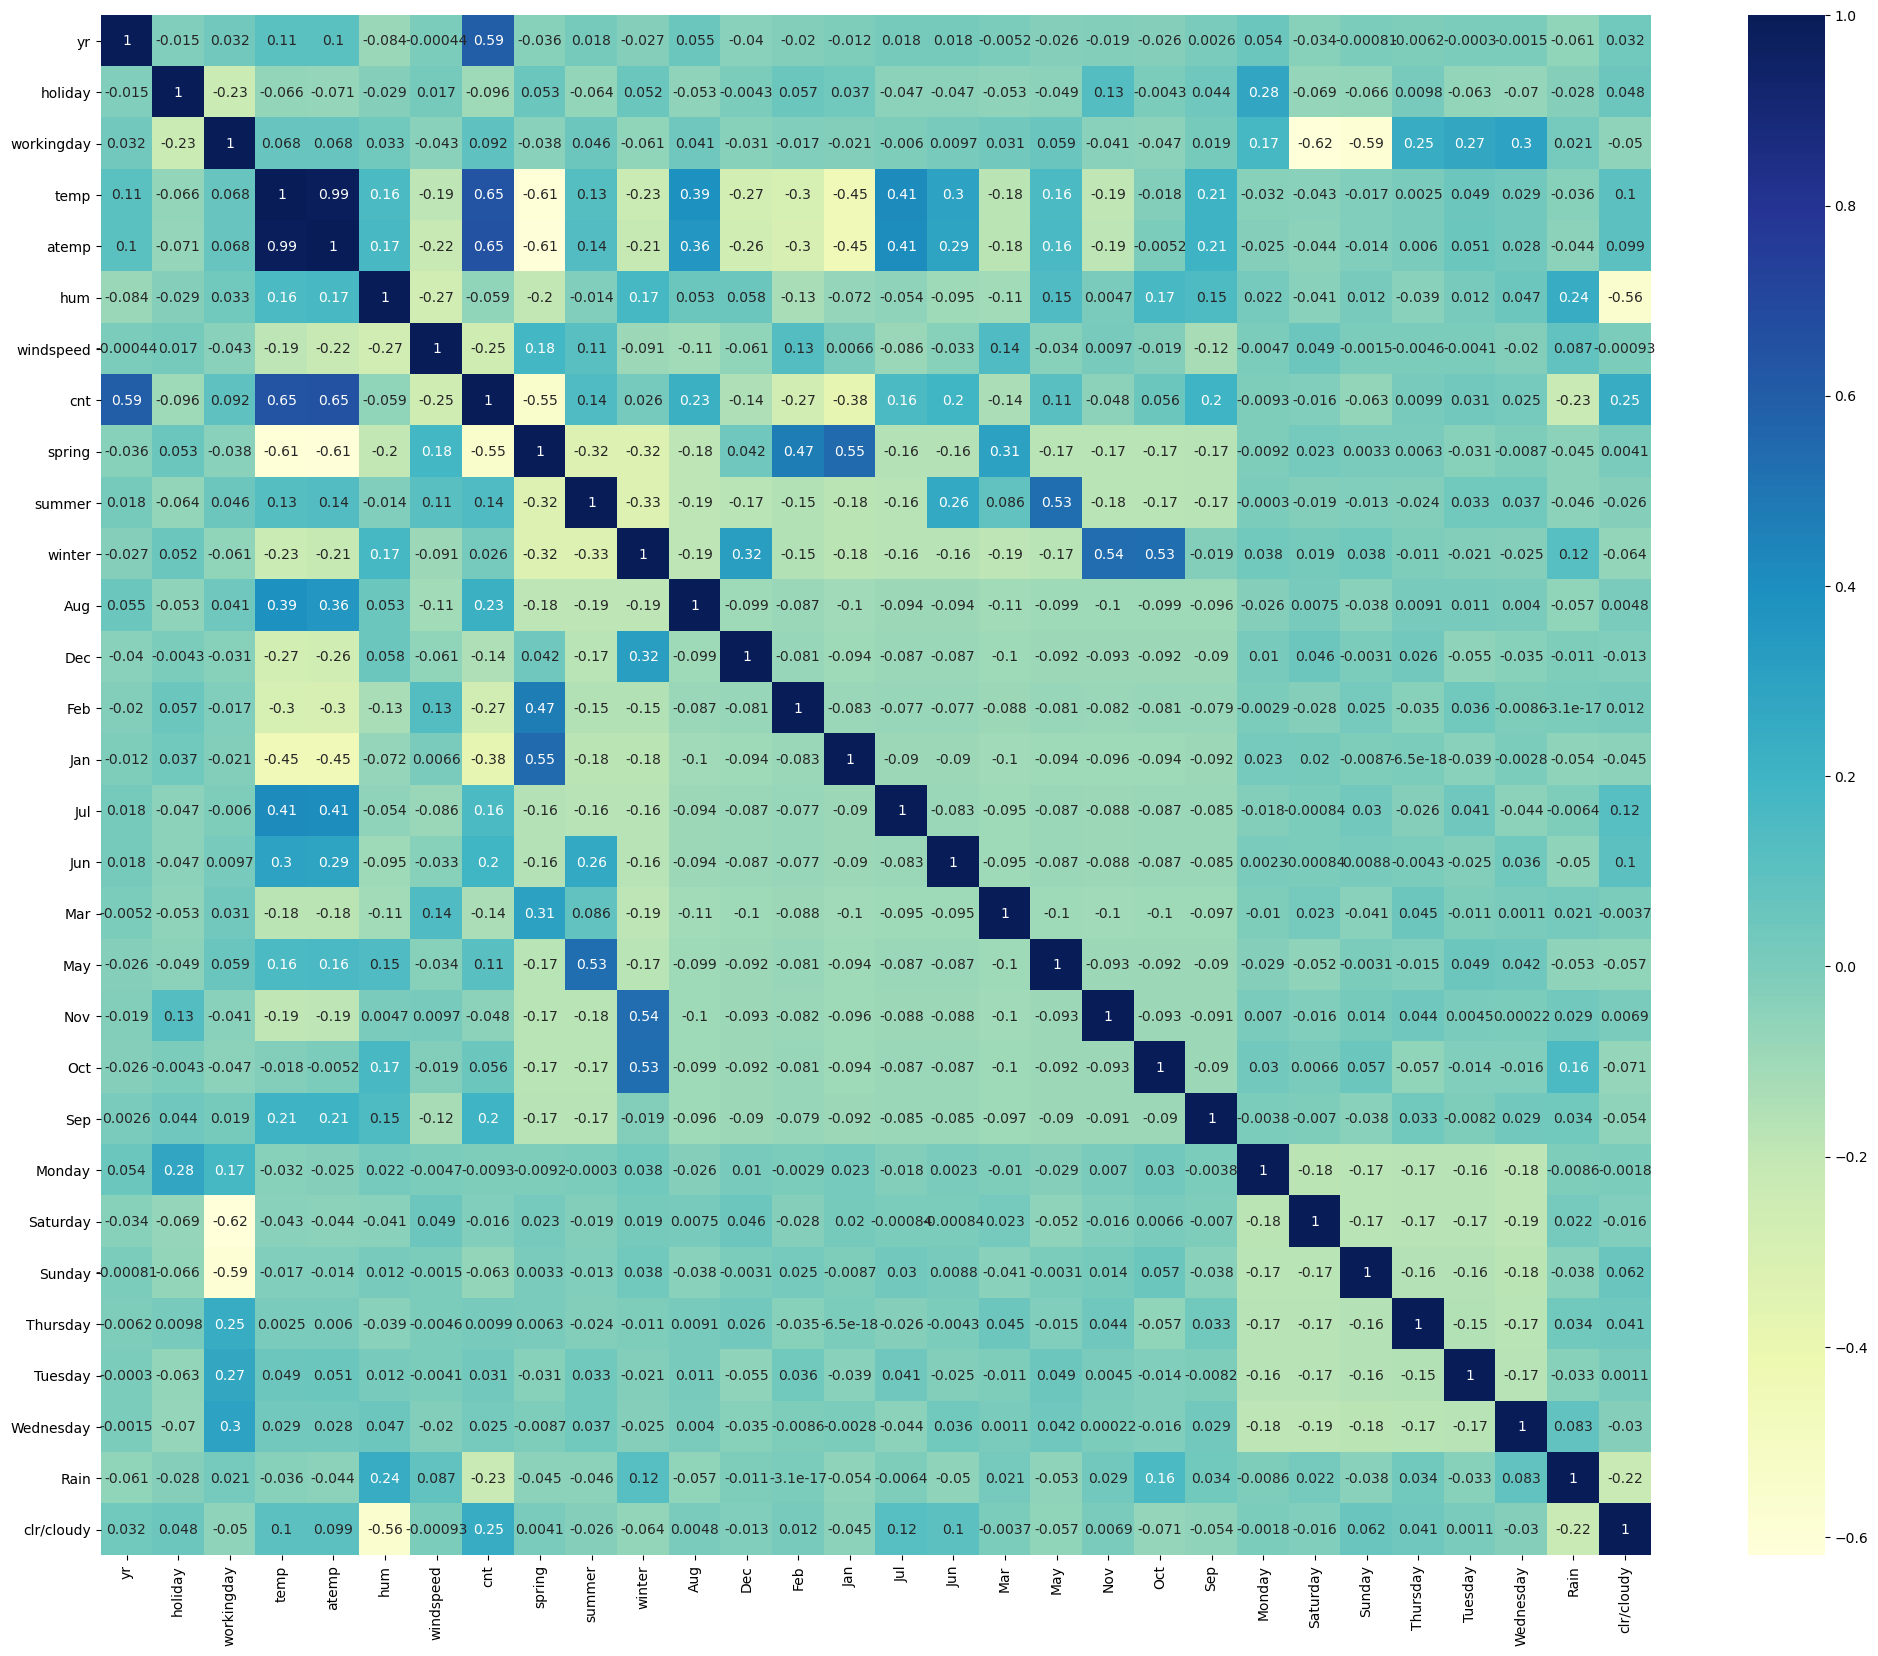

In [40]:
plt.figure(figsize = (25,20))
sns.heatmap(day_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

### The predictors "yr", "temp", "otemp" seem to be more correlated with target variable. However we use RFE to come up with the most eligible predictors

In [41]:
y_train = day_train.pop("cnt")
X_train=day_train

In [42]:
X_train.shape


(510, 29)

In [43]:
y_train.shape

(510,)

## Building a Linear Model using RFE

In [44]:
## Initiating the object and fit model
lm = LinearRegression() 
lm.fit(X_train,y_train)

LinearRegression()

In [45]:
rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [46]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 5),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Aug', False, 7),
 ('Dec', False, 3),
 ('Feb', False, 4),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 14),
 ('Mar', False, 15),
 ('May', False, 6),
 ('Nov', False, 2),
 ('Oct', False, 13),
 ('Sep', True, 1),
 ('Monday', False, 9),
 ('Saturday', True, 1),
 ('Sunday', False, 8),
 ('Thursday', False, 11),
 ('Tuesday', False, 10),
 ('Wednesday', False, 12),
 ('Rain', True, 1),
 ('clr/cloudy', True, 1)]

In [47]:
X_train.columns[rfe.support_]

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'summer', 'winter', 'Jan', 'Jul', 'Sep', 'Saturday', 'Rain',
       'clr/cloudy'],
      dtype='object')

In [48]:
X_train_RFE = X_train[X_train.columns[rfe.support_]]

In [49]:
X_train_RFE.head()

,yr,holiday,workingday,temp,hum,windspeed,spring,summer,winter,Jan,Jul,Sep,Saturday,Rain,clr/cloudy
576,1,0,1,0.815169,0.725633,0.264686,0,0,0,0,1,0,0,0,1
426,1,0,0,0.442393,0.640189,0.255342,1,0,0,0,0,0,1,0,0
728,1,0,0,0.245101,0.498067,0.663106,1,0,0,0,0,0,0,0,1
482,1,0,0,0.395666,0.504508,0.188475,0,1,0,0,0,0,1,0,0
111,0,0,1,0.345824,0.751824,0.380981,0,1,0,0,0,0,0,0,0


In [50]:
X_train_RFE = sm.add_constant(X_train_RFE)
X_train_RFE.head()

,const,yr,holiday,workingday,temp,hum,windspeed,spring,summer,winter,Jan,Jul,Sep,Saturday,Rain,clr/cloudy
576,1.0,1,0,1,0.815169,0.725633,0.264686,0,0,0,0,1,0,0,0,1
426,1.0,1,0,0,0.442393,0.640189,0.255342,1,0,0,0,0,0,1,0,0
728,1.0,1,0,0,0.245101,0.498067,0.663106,1,0,0,0,0,0,0,0,1
482,1.0,1,0,0,0.395666,0.504508,0.188475,0,1,0,0,0,0,1,0,0
111,1.0,0,0,1,0.345824,0.751824,0.380981,0,1,0,0,0,0,0,0,0


In [51]:
# Running the linear model
lm1 = sm.OLS(y_train,X_train_RFE).fit()

In [52]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.0
Date:                Sat, 11 Nov 2023   Prob (F-statistic):          4.22e-191
Time:                        21:00:50   Log-Likelihood:                 519.65
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1956      0.040      4.932      0.000       0.118       0.273
yr             0.2305      0.008     28.795      0.000       0.215       0.246
holiday       -0.0582      0.027     -2.164      0.031      -0.111      -0.005
workingday     0.0433      0.012      3.762      0.000       0.021       0.066
temp           0.5096      0.034     14.837      0.000       0.442       0.577
hum           -0.1563      0.037     -4.188      0.000      -0.230      -0.083
windspeed     -0.1863      0.025     -7.310      0.000      -0.236      -0.136
spring        -0.0509      0.021     -2.464      0.014      -0.091      -0.010
summer         0.0508      0.015      3.423      0.001       0.022       0.080
winter         0.0933      0.017      5.403      0.000       0.059       0.127
Jan           -0.0345      0.017     -1.989      0.047      -0.069      -0.000
Jul           -0.0529      0.018     -2.931      0.004      -0.088      -0.017
Sep            0.0814      0.016      4.945      0.000       0.049       0.114
Saturday       0.0536      0.014      3.694      0.000       0.025       0.082
Rain          -0.1911      0.025     -7.755      0.000      -0.240      -0.143
clr/cloudy     0.0563      0.010      5.439      0.000       0.036       0.077
==============================================================================
Omnibus:                       66.260   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.826
Skew:                          -0.678   Prob(JB):                     1.97e-35
Kurtosis:                       5.383   Cond. No.                         24.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Here we observe that p-value of all the variables are less than 0.05. Hence we need to go about with VIF to decide the predictor variables

In [53]:
vif = pd.DataFrame()
X = X_train_RFE
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,101.81
7,spring,5.08
4,temp,3.89
9,winter,3.59
8,summer,2.65
5,hum,1.91
3,workingday,1.88
13,Saturday,1.78
15,clr/cloudy,1.63
10,Jan,1.57


### Here we observe that VIF of all the variables are less than 5 with an exception of Spring so we can safely remove Spring var

In [54]:
X_train_mod = X_train_RFE.drop(['spring'],axis=1)

In [55]:
X_train_mod.columns

Index(['const', 'yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'summer', 'winter', 'Jan', 'Jul', 'Sep', 'Saturday', 'Rain',
       'clr/cloudy'],
      dtype='object')

In [56]:
lm = LinearRegression() 
lm.fit(X_train_mod,y_train)

LinearRegression()

In [57]:
lm2 = sm.OLS(y_train,X_train_mod).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     194.8
Date:                Sat, 11 Nov 2023   Prob (F-statistic):          5.98e-191
Time:                        21:00:51   Log-Likelihood:                 516.53
No. Observations:                 510   AIC:                            -1003.
Df Residuals:                     495   BIC:                            -939.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1469      0.035      4.251      0.000       0.079       0.215
yr             0.2294      0.008     28.555      0.000       0.214       0.245
holiday       -0.0596      0.027     -2.206      0.028      -0.113      -0.007
workingday     0.0437      0.012      3.774      0.000       0.021       0.066
temp           0.5676      0.025     22.556      0.000       0.518       0.617
hum           -0.1659      0.037     -4.446      0.000      -0.239      -0.093
windspeed     -0.1935      0.025     -7.606      0.000      -0.243      -0.144
summer         0.0757      0.011      6.950      0.000       0.054       0.097
winter         0.1255      0.011     11.081      0.000       0.103       0.148
Jan           -0.0393      0.017     -2.271      0.024      -0.073      -0.005
Jul           -0.0442      0.018     -2.486      0.013      -0.079      -0.009
Sep            0.0928      0.016      5.847      0.000       0.062       0.124
Saturday       0.0539      0.015      3.696      0.000       0.025       0.082
Rain          -0.1892      0.025     -7.640      0.000      -0.238      -0.141
clr/cloudy     0.0541      0.010      5.221      0.000       0.034       0.075
==============================================================================
Omnibus:                       60.708   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.130
Skew:                          -0.660   Prob(JB):                     3.35e-29
Kurtosis:                       5.104   Cond. No.                         22.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
vif = pd.DataFrame()
X = X_train_mod
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,76.58
4,temp,2.07
5,hum,1.89
3,workingday,1.88
12,Saturday,1.78
14,clr/cloudy,1.61
9,Jan,1.55
8,winter,1.53
10,Jul,1.43
7,summer,1.41


### On the basis of the above analysis we can conslude that the model2 (lm2) can be taken as a final model.

### Residual Analysis

In [62]:
y_train_cnt = lm2.predict(X_train_mod)

Text(0.5, 0, 'Errors')

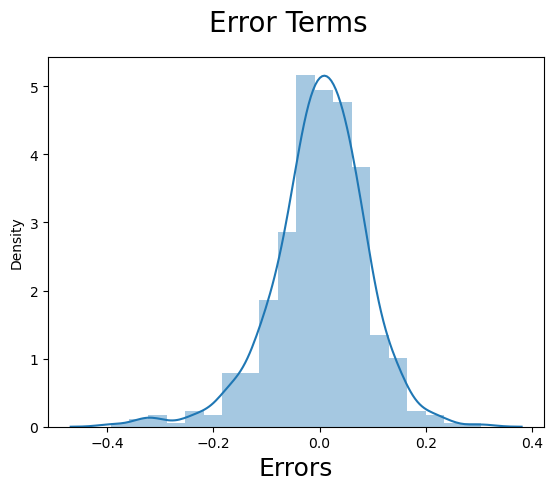

In [63]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Error terms seem to follow normal distribution. So lets now make predictions on test set

## Predictions on Test Sets

In [64]:
# Scaling the test set
Scaler = MinMaxScaler()

In [65]:
num_vars = ['temp','atemp','hum','windspeed','cnt']

day_test[num_vars] = scaler.transform(day_test[num_vars])


In [77]:
y_test.shape

(220,)

In [78]:
 day_test.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'spring', 'summer', 'winter', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun',
       'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'Rain', 'clr/cloudy'],
      dtype='object')

In [79]:
X_test = day_test

In [80]:
X_test.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'spring', 'summer', 'winter', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun',
       'Mar', 'May', 'Nov', 'Oct', 'Sep', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'Rain', 'clr/cloudy'],
      dtype='object')

In [81]:
X_train_mod.columns

Index(['const', 'yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'summer', 'winter', 'Jan', 'Jul', 'Sep', 'Saturday', 'Rain',
       'clr/cloudy'],
      dtype='object')

In [103]:
X_train_mod = X_train_mod.pop('const')

X.head()

,yr,holiday,workingday,temp,hum,windspeed,summer,winter,Jan,Jul,Sep,Saturday,Rain,clr/cloudy
576,1,0,1,0.815169,0.725633,0.264686,0,0,0,1,0,0,0,1
426,1,0,0,0.442393,0.640189,0.255342,0,0,0,0,0,1,0,0
728,1,0,0,0.245101,0.498067,0.663106,0,0,0,0,0,0,0,1
482,1,0,0,0.395666,0.504508,0.188475,1,0,0,0,0,1,0,0
111,0,0,1,0.345824,0.751824,0.380981,1,0,0,0,0,0,0,0


In [104]:
X_test_final = X_test[X.columns]


In [105]:
X_test_final.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'summer',
       'winter', 'Jan', 'Jul', 'Sep', 'Saturday', 'Rain', 'clr/cloudy'],
      dtype='object')

In [106]:
X_test_final = sm.add_constant(X_test_final)

In [107]:
# Making predictions
y_pred = lm2.predict(X_test_final)

## Model Evaluation

Text(0, 0.5, 'y_pred')

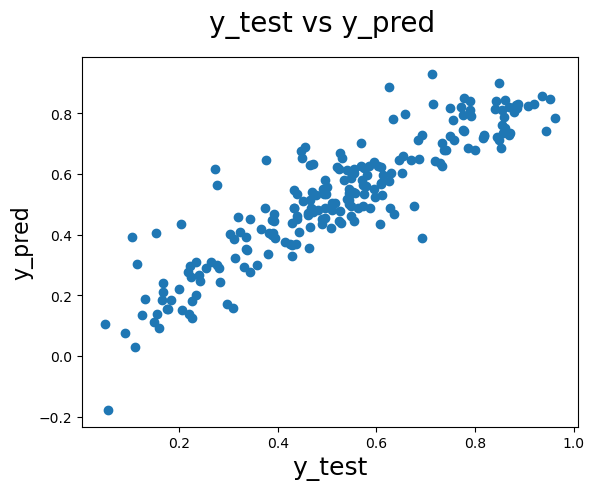

In [108]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [112]:
# Calculating R2 for the test data set
r2_score(y_test, y_pred)


0.805348463686337

## Conclusion
### Comparing R2 of train set and test set
#### - R2 of train set is 0.84
#### - R2 of test set is 0.8053
### Based on above graph we can conclude that the the model is accurate and make the predictions based on the decided features significantly